# Luderick Object Detection Using YOLOv5 (Inference)

## Load the preprocessed DataFrames generated in the preprocessing Notebook

In [1]:
# all imports
import pandas as pd
import numpy as np
import torch
import ast
import cv2
import matplotlib.pyplot as plt
import time
from PIL import Image
import os

plt.style.use('ggplot')

In [2]:
# Constants
MODELS_DIR = 'models'
IMAGES_DIR = 'Fish_automated_identification_and_counting/luderick-seagrass'
VIDEOS_DIR = 'Fish_automated_identification_and_counting/videos'
CLASSES = ['luderick']
NUM_CLASSES = len(CLASSES)
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
INFERENCE_OUTPUT_DIR = 'inference_outputs'
!mkdir {INFERENCE_OUTPUT_DIR}

Ya existe el subdirectorio o el archivo inference_outputs.


In [3]:
def load_luderick_df(file_path):
    """
    Loads a preprocessed luderick dataframe from a .csv and converts its 
    array column from string to a proper array
    """
    loaded_df = pd.read_csv(file_path)
    loaded_df['labels'] = loaded_df['labels'].apply(lambda x: ast.literal_eval(x))
    loaded_df['bounding_boxes'] = loaded_df['bounding_boxes'].apply(lambda x: ast.literal_eval(x))
    loaded_df['area'] = loaded_df['area'].apply(lambda x: ast.literal_eval(x))
    loaded_df['segmentation'] = loaded_df['segmentation'].apply(lambda x: ast.literal_eval(x))
    
    return loaded_df

In [4]:
validation_df = load_luderick_df('luderick_validation_preprocessed.csv')
test_df = load_luderick_df('luderick_test_preprocessed.csv')

validation_df

,image_name,video_name,frame_number,number_boxes,labels,bounding_boxes,area,segmentation
0,04C2_Luderick_16_000400.jpg,04C2_Luderick_16,1,1,[1],"[[2, 581, 163, 755]]",[28014],"[[163, 703, 146, 678, 125, 649, 93, 620, 58, 6..."
1,04C2_Luderick_16_000600.jpg,04C2_Luderick_16,2,1,[1],"[[2, 586, 223, 765]]",[39559],"[[223, 711, 218, 728, 195, 731, 131, 746, 107,..."
2,04C2_Luderick_16_000800.jpg,04C2_Luderick_16,3,1,[1],"[[0, 589, 281, 760]]",[48051],"[[281, 703, 279, 722, 237, 732, 165, 751, 98, ..."
3,04C2_Luderick_16_001000.jpg,04C2_Luderick_16,4,1,[1],"[[2, 588, 339, 748]]",[53920],"[[339, 700, 307, 711, 276, 726, 232, 737, 220,..."
4,04C2_Luderick_16_001200.jpg,04C2_Luderick_16,5,1,[1],"[[2, 580, 380, 746]]",[62748],"[[380, 678, 354, 646, 308, 607, 253, 581, 200,..."
...,...,...,...,...,...,...,...,...
819,C1_Luderick_14.mov_5fps_000013.jpg,C1_Luderick_14,13,3,"[1, 1, 1]","[[414, 235, 701, 432], [1584, 449, 1868, 590],...","[56539, 40044, 24924]","[[701, 235, 699, 250, 699, 273, 692, 310, 690,..."
820,C1_Luderick_14.mov_5fps_000014.jpg,C1_Luderick_14,14,3,"[1, 1, 1]","[[320, 254, 573, 449], [1457, 310, 1714, 451],...","[49335, 36237, 42000]","[[573, 254, 573, 271, 566, 314, 560, 335, 556,..."
821,C1_Luderick_14.mov_5fps_000015.jpg,C1_Luderick_14,15,4,"[1, 1, 1, 1]","[[1455, 476, 1737, 611], [1397, 304, 1697, 444...","[38070, 42000, 12314, 40425]","[[1716, 476, 1716, 504, 1722, 526, 1737, 570, ..."
822,C1_Luderick_14.mov_5fps_000016.jpg,C1_Luderick_14,16,3,"[1, 1, 1]","[[214, 314, 372, 504], [1325, 303, 1703, 442],...","[30020, 52542, 38676]","[[372, 314, 370, 327, 365, 344, 355, 372, 331,..."


## Load YOLOv5 Model

### YOLOv5s small size model

In [5]:
model_path = f"{MODELS_DIR}/best_YOLOv5s_model_1.pt" 
model_s = torch.hub.load('ultralytics/yolov5', 'custom', path=model_path)  # local model
model_s.to(DEVICE).eval();

Using cache found in C:\Users\Ricard/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2022-5-8 torch 1.11.0 CUDA:0 (NVIDIA GeForce GTX 970, 4096MiB)

Fusing layers... 
Model summary: 213 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


### YOLOv5m medium size model

In [5]:
model_path = f"{MODELS_DIR}/best_YOLOv5m_model_1.pt" 
model_m = torch.hub.load('ultralytics/yolov5', 'custom', path=model_path)  # local model
model_m.to(DEVICE).eval();

Using cache found in C:\Users\Ricard/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2022-5-8 torch 1.11.0 CUDA:0 (NVIDIA GeForce GTX 970, 4096MiB)

Fusing layers... 
Model summary: 290 layers, 20852934 parameters, 0 gradients, 47.9 GFLOPs
Adding AutoShape... 


### YOLOv5l large size model

In [51]:
model_path = f"{MODELS_DIR}/best_YOLOv5l_model_1.pt" 
model_l = torch.hub.load('ultralytics/yolov5', 'custom', path=model_path)  # local model
model_l.to(DEVICE).eval();

Using cache found in C:\Users\Ricard/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2022-5-8 torch 1.11.0 CUDA:0 (NVIDIA GeForce GTX 970, 4096MiB)

Fusing layers... 
Model summary: 367 layers, 46108278 parameters, 0 gradients, 107.8 GFLOPs
Adding AutoShape... 


In [6]:
# Visualize the model's prediction format
image = Image.open(f"{IMAGES_DIR}/C1_Luderick_14.mov_5fps_000013.jpg")
results = model_m(image)
results.print()
results.pandas().xyxy[0]

image 1/1: 1080x1920 3 ludericks
Speed: 31.0ms pre-process, 27.0ms inference, 6.0ms NMS per image at shape (1, 3, 384, 640)


,xmin,ymin,xmax,ymax,confidence,class,name
0,397.627563,236.689697,697.171753,437.110107,0.943445,0,luderick
1,1582.460205,437.462463,1865.663574,587.593262,0.927670,0,luderick
2,1516.050781,318.521057,1729.309570,451.021301,0.904255,0,luderick


 ## Predict Function

In [6]:
def predict(image, model):
    """
    Return, as arrays, the detection bounding boxes, labels, pred_scores and inference time in an PIL Image (RGB) using a 
    given model above a given detection_threshold.
    """ 
    start_time = time.time()
    with torch.no_grad():
        results = model(image) # get the predictions on the image
    end_time = time.time()
    inference_time = end_time - start_time
    
    # get the results as a pandas dataframe
    results_pandas = results.pandas().xyxy[0]
    
    return results_pandas, inference_time

## Function to Draw Bounding Boxes Around an Object

A bounding box has a format of [x_min, y_min, x_max, y_max]

In [7]:
def draw_boxes(results_df, image, color=(255, 0, 0)):
    """
    Returns an image array that contains the predicted bounding boxes, labels and scores
    """
    # read the image with OpenCV
    image = np.asarray(image)
    for index, row in results_df.iterrows():
        box = [row['xmin'], row['ymin'], row['xmax'], row['ymax']]
        cv2.rectangle(image,
                     (int(box[0]), int(box[1])), (int(box[2]), int(box[3])),
                     color, 2)
        bbox_text = f"{row['name']} {str(round(row['confidence']*100, 2))}" # showing probability scores
        cv2.putText(image, bbox_text, (int(box[0]), int(box[1] - 5)),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2,
                   lineType=cv2.LINE_AA)
    
    return image

In [8]:
def view_image(image_array):
    """
    Display the image array
    """
    image = Image.fromarray((image_array).astype(np.uint8))  # Pil Image needs the image to be in int format
    display(image)

Inference time = 0.0379946231842041 seconds


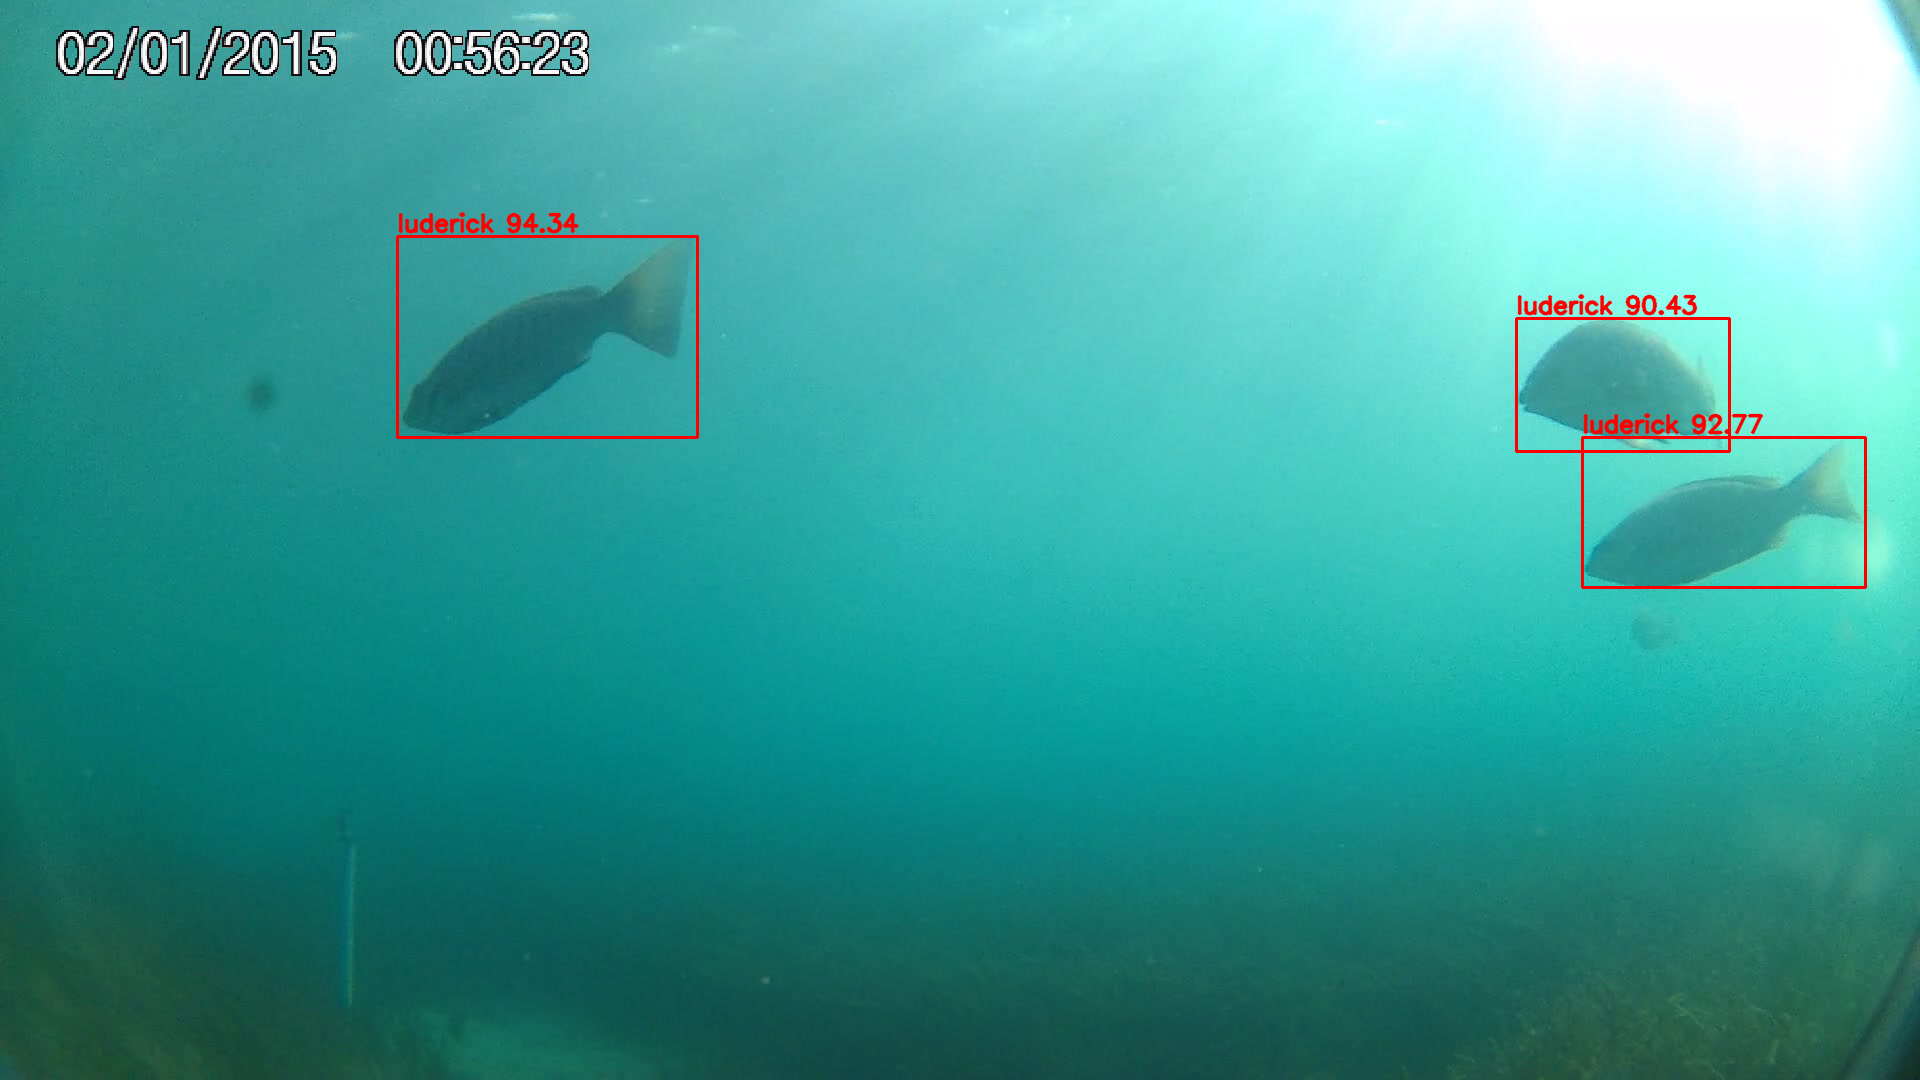

In [41]:
# visualize predicted bounding boxes from one image from the validation dataset

# Some PIL Images converted to arrays have 4 color channel unless .convert('RGB') is used
image = Image.open(f"{IMAGES_DIR}/C1_Luderick_14.mov_5fps_000013.jpg").convert('RGB') 
# set detection threshold
model_m.conf = 0.8
# predict results
results_df, inf_time = predict(image, model_m)
image_boxes = draw_boxes(results_df, image)
print(f'Inference time = {inf_time} seconds')
view_image(image_boxes)
torch.cuda.empty_cache()

## Inference on the full dataset

In [9]:
def predict_whole_dataset(luderick_df, model, images_dir, output_dir, score_threshold=0.8):
    """
    Carry out object detection on all the images from a preprocessed luderick dataset
    and save them with bounding boxes, labels and prediction scores printed at the desired folder
    """
    image_names = luderick_df['image_name'].values
    total_fps = 0
    frame_count = 0
    # set model confidence score threshold
    model.conf = score_threshold
    
    for i, image_name in enumerate(image_names):
            # load the image
            image = Image.open(f"{images_dir}/{image_name}").convert('RGB') 
            # use the model to get the predictions
            results_df, inf_time = predict(image, model)
            # draw the image boxes
            image_boxes = draw_boxes(results_df, image)
            # get the current fps
            fps = 1 / inf_time
            # increase total fps
            total_fps += fps
            # increment frame count
            frame_count += 1
            image_boxes = cv2.cvtColor(image_boxes, cv2.COLOR_BGR2RGB).astype(np.float32)
            cv2.imwrite(f"{output_dir}/{image_name}", image_boxes)
            print(f"Detection on image {i+1} finished...")
            print('-'*50)
    
    print('Dataset detection completed.')
    # calculate and print the average FPS
    avg_fps = total_fps / frame_count
    print(f"Average FPS: {avg_fps:.3f}")

### YOLOV5m medium model

In [12]:
folder_name = 'validation_images_YOLOv5m_model_1'
%cd {INFERENCE_OUTPUT_DIR}
!mkdir {folder_name}
%cd ..

output_dir = f"{INFERENCE_OUTPUT_DIR}/{folder_name}"
predict_whole_dataset(validation_df, model_m, IMAGES_DIR, output_dir, 0.8)
torch.cuda.empty_cache()

C:\Users\Ricard\Desktop\Master\TFM\notebooks\Luderick_Seagrass\inference_outputs
C:\Users\Ricard\Desktop\Master\TFM\notebooks\Luderick_Seagrass


Ya existe el subdirectorio o el archivo validation_images_YOLOv5m_model_1.


Detection on image 1 finished...
--------------------------------------------------
Detection on image 2 finished...
--------------------------------------------------
Detection on image 3 finished...
--------------------------------------------------
Detection on image 4 finished...
--------------------------------------------------
Detection on image 5 finished...
--------------------------------------------------
Detection on image 6 finished...
--------------------------------------------------
Detection on image 7 finished...
--------------------------------------------------
Detection on image 8 finished...
--------------------------------------------------
Detection on image 9 finished...
--------------------------------------------------
Detection on image 10 finished...
--------------------------------------------------
Detection on image 11 finished...
--------------------------------------------------
Detection on image 12 finished...
----------------------------------------

Detection on image 98 finished...
--------------------------------------------------
Detection on image 99 finished...
--------------------------------------------------
Detection on image 100 finished...
--------------------------------------------------
Detection on image 101 finished...
--------------------------------------------------
Detection on image 102 finished...
--------------------------------------------------
Detection on image 103 finished...
--------------------------------------------------
Detection on image 104 finished...
--------------------------------------------------
Detection on image 105 finished...
--------------------------------------------------
Detection on image 106 finished...
--------------------------------------------------
Detection on image 107 finished...
--------------------------------------------------
Detection on image 108 finished...
--------------------------------------------------
Detection on image 109 finished...
---------------------

Detection on image 194 finished...
--------------------------------------------------
Detection on image 195 finished...
--------------------------------------------------
Detection on image 196 finished...
--------------------------------------------------
Detection on image 197 finished...
--------------------------------------------------
Detection on image 198 finished...
--------------------------------------------------
Detection on image 199 finished...
--------------------------------------------------
Detection on image 200 finished...
--------------------------------------------------
Detection on image 201 finished...
--------------------------------------------------
Detection on image 202 finished...
--------------------------------------------------
Detection on image 203 finished...
--------------------------------------------------
Detection on image 204 finished...
--------------------------------------------------
Detection on image 205 finished...
-------------------

Detection on image 290 finished...
--------------------------------------------------
Detection on image 291 finished...
--------------------------------------------------
Detection on image 292 finished...
--------------------------------------------------
Detection on image 293 finished...
--------------------------------------------------
Detection on image 294 finished...
--------------------------------------------------
Detection on image 295 finished...
--------------------------------------------------
Detection on image 296 finished...
--------------------------------------------------
Detection on image 297 finished...
--------------------------------------------------
Detection on image 298 finished...
--------------------------------------------------
Detection on image 299 finished...
--------------------------------------------------
Detection on image 300 finished...
--------------------------------------------------
Detection on image 301 finished...
-------------------

Detection on image 386 finished...
--------------------------------------------------
Detection on image 387 finished...
--------------------------------------------------
Detection on image 388 finished...
--------------------------------------------------
Detection on image 389 finished...
--------------------------------------------------
Detection on image 390 finished...
--------------------------------------------------
Detection on image 391 finished...
--------------------------------------------------
Detection on image 392 finished...
--------------------------------------------------
Detection on image 393 finished...
--------------------------------------------------
Detection on image 394 finished...
--------------------------------------------------
Detection on image 395 finished...
--------------------------------------------------
Detection on image 396 finished...
--------------------------------------------------
Detection on image 397 finished...
-------------------

Detection on image 482 finished...
--------------------------------------------------
Detection on image 483 finished...
--------------------------------------------------
Detection on image 484 finished...
--------------------------------------------------
Detection on image 485 finished...
--------------------------------------------------
Detection on image 486 finished...
--------------------------------------------------
Detection on image 487 finished...
--------------------------------------------------
Detection on image 488 finished...
--------------------------------------------------
Detection on image 489 finished...
--------------------------------------------------
Detection on image 490 finished...
--------------------------------------------------
Detection on image 491 finished...
--------------------------------------------------
Detection on image 492 finished...
--------------------------------------------------
Detection on image 493 finished...
-------------------

Detection on image 578 finished...
--------------------------------------------------
Detection on image 579 finished...
--------------------------------------------------
Detection on image 580 finished...
--------------------------------------------------
Detection on image 581 finished...
--------------------------------------------------
Detection on image 582 finished...
--------------------------------------------------
Detection on image 583 finished...
--------------------------------------------------
Detection on image 584 finished...
--------------------------------------------------
Detection on image 585 finished...
--------------------------------------------------
Detection on image 586 finished...
--------------------------------------------------
Detection on image 587 finished...
--------------------------------------------------
Detection on image 588 finished...
--------------------------------------------------
Detection on image 589 finished...
-------------------

Detection on image 674 finished...
--------------------------------------------------
Detection on image 675 finished...
--------------------------------------------------
Detection on image 676 finished...
--------------------------------------------------
Detection on image 677 finished...
--------------------------------------------------
Detection on image 678 finished...
--------------------------------------------------
Detection on image 679 finished...
--------------------------------------------------
Detection on image 680 finished...
--------------------------------------------------
Detection on image 681 finished...
--------------------------------------------------
Detection on image 682 finished...
--------------------------------------------------
Detection on image 683 finished...
--------------------------------------------------
Detection on image 684 finished...
--------------------------------------------------
Detection on image 685 finished...
-------------------

Detection on image 770 finished...
--------------------------------------------------
Detection on image 771 finished...
--------------------------------------------------
Detection on image 772 finished...
--------------------------------------------------
Detection on image 773 finished...
--------------------------------------------------
Detection on image 774 finished...
--------------------------------------------------
Detection on image 775 finished...
--------------------------------------------------
Detection on image 776 finished...
--------------------------------------------------
Detection on image 777 finished...
--------------------------------------------------
Detection on image 778 finished...
--------------------------------------------------
Detection on image 779 finished...
--------------------------------------------------
Detection on image 780 finished...
--------------------------------------------------
Detection on image 781 finished...
-------------------

## Inference on videos

In [10]:
def detect_video(video_path, model, output_dir='.', detection_threshold=0.8, save_video=True):
    """
    Carries out detection on a video frame by frame, showing it in real time in an opencv window and showing the framerate. 
    It also saves the video at 30 fps as a .mp4
    """
    # set model confidence score threshold
    model.conf = detection_threshold
    # start videocaptures
    cap = cv2.VideoCapture(video_path)
    
    if (cap.isOpened() == False):
        print('Error while trying to read video. Please check path again')
    
    # get the frame width and height
    frame_width = int(cap.get(3))
    frame_height = int(cap.get(4))
    
    save_name = f"{video_path.split('/')[-1].split('.')[0]}"
    # define codec and create VideoWriter object
    if save_video:
        out = cv2.VideoWriter(f"{output_dir}/{save_name}.mp4",
                             cv2.VideoWriter_fourcc(*'mp4v'), 30,
                             (frame_width, frame_height))
    
    frame_count = 0 # to count total frames
    total_fps = 0 # to get the final frames per second
    
    # Reading Frames and Detecting Objects
    # read until end of video
    while(cap.isOpened()):
        # capture each frame of the video
        ret, frame = cap.read()
        # while the video isn't finished...
        if ret:
            image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            #image = Image.fromarray((image).astype(np.uint8)).convert("RGB")
            with torch.no_grad():
                # get predictions for the current frame
                results_df, inf_time = predict(image, model)
            
            # draw boxes and show current frame on screen
            image = draw_boxes(results_df, image)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            # get the inference time fps
            fps = 1 / inf_time
            # add fps tot total fps
            total_fps += fps
            # increment frame count
            frame_count += 1
            image = cv2.putText(image, f"{fps:.1f} FPS", 
                        (image.shape[1]-200, 25),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 
                        2, lineType=cv2.LINE_AA)
            
            # Display frames in a window
            # press 'q' to exit
            wait_time = max(1, int(fps/4))
            cv2.imshow('image', image)
            if save_video:
                out.write(image)
            if cv2.waitKey(wait_time) & 0xFF == ord('q'):
                break
                
        else:
            break
      
    # release VideoCapture()
    cap.release()
    # close all frames and video windows
    cv2.destroyAllWindows()
    
    # calculate and print the average fps
    avg_fps = total_fps / frame_count
    print(f"Average FPS: {avg_fps:.3f}")

### YOLOV5s small model

In [12]:
folder_name = 'validation_video_YOLOv5s_model_1'
%cd {INFERENCE_OUTPUT_DIR}
!mkdir {folder_name}
%cd ..
video_path = f"{VIDEOS_DIR}/validation/2205_Luderick_25.mov"
output_dir = f"{INFERENCE_OUTPUT_DIR}/{folder_name}"

detect_video(video_path, model_s, output_dir, detection_threshold=0.6, save_video=True)
torch.cuda.empty_cache()

C:\Users\Ricard\Desktop\Master\TFM\notebooks\Luderick_Seagrass\inference_outputs
C:\Users\Ricard\Desktop\Master\TFM\notebooks\Luderick_Seagrass


Ya existe el subdirectorio o el archivo validation_video_YOLOv5s_model_1.


Average FPS: 43.738


### YOLOV5m medium model

In [15]:
folder_name = 'validation_video_YOLOv5m_model_1'
%cd {INFERENCE_OUTPUT_DIR}
!mkdir {folder_name}
%cd ..
video_path = f"{VIDEOS_DIR}/validation/2205_Luderick_25.mov"
output_dir = f"{INFERENCE_OUTPUT_DIR}/{folder_name}"

detect_video(video_path, model_m, output_dir, detection_threshold=0.6, save_video=True)
torch.cuda.empty_cache()

C:\Users\Ricard\Desktop\Master\TFM\notebooks\Luderick_Seagrass\inference_outputs
C:\Users\Ricard\Desktop\Master\TFM\notebooks\Luderick_Seagrass


Ya existe el subdirectorio o el archivo validation_video_YOLOv5m_model_1.


Average FPS: 33.749


### YOLOv5l large model

In [52]:
folder_name = 'validation_video_YOLOv5l_model_1'
%cd {INFERENCE_OUTPUT_DIR}
!mkdir {folder_name}
%cd ..
video_path = f"{VIDEOS_DIR}/validation/2205_Luderick_25.mov"
output_dir = f"{INFERENCE_OUTPUT_DIR}/{folder_name}"

detect_video(video_path, model_l, output_dir, detection_threshold=0.6, save_video=True)
torch.cuda.empty_cache()

C:\Users\Ricard\Desktop\Master\TFM\notebooks\Luderick_Seagrass\inference_outputs
C:\Users\Ricard\Desktop\Master\TFM\notebooks\Luderick_Seagrass
Average FPS: 21.418


### Average FPS for each YOLOv5 model size option:

* YOLOv5s (small) = 43.7 fps
* YOLOv5m (medium) = 33.7 fps
* YOLO v5l (large) = 21.4 fps

## Model Evaluation using Mean Average Precision (mAP)

### Function to compute the Intersection Over Union (IOU)

The IOU is the ratio between the area of the intersection between two boxes and the area of their union

In [16]:
def IOU(box_1, box_2):
    """
    Computes the Intersection Over Union (IOU) between two bounding boxes formatted as [x_min, y_min, x_max, y_max]
    """
    # get the right-most left edge between the two bounding boxes
    max_left = max(box_1[0], box_2[0])
    # get the left-most right edge between the two bounding boxes
    min_right = min(box_1[2], box_2[2])
    # compute the intersection width
    intersection_width = min_right - max_left
    
    # get the lowest top edge (y is bigger as it goes lower)
    max_top = max(box_1[1], box_2[1])
    # get the highest bottom edge
    min_bottom = min(box_1[3], box_2[3])
    # compute the intersection height
    intersection_height = min_bottom - max_top
    
    # if the boxes don't intersect, intersection_width or height will be negative
    intersection_area = max(0, intersection_width) * max(0, intersection_height)
    box_1_area = (box_1[2] - box_1[0]) * (box_1[3] - box_1[1])
    box_2_area = (box_2[2] - box_2[0]) * (box_2[3] - box_2[1])
    # get the union area by adding the boxes areas and substracting their intersection
    union_area = box_1_area + box_2_area - intersection_area
    # get the final iou
    iou = intersection_area / union_area
    
    return iou

### Functions to generate a dataframe with info of each predicted bounding box
It includes:
 * Name of the image where the predicted box is
 * Label id of the prediction (class id)
 * Confidence score of the prediction
 * The ground truth box id (in respect to the image) with the highest IOU (-1 if none found)
 * The highest IOU with any ground truth box

In [17]:
def get_image_box_evaluation_dataframe(results_df, true_boxes, true_labels):
    """
    Returns the box evaluation dataframe of a single image and class
    """
    ious_gt_box_index = np.array([-1] * len(results_df))
    ious = np.zeros(len(results_df))
    pred_scores = results_df['confidence'].values
    for index, row in results_df.iterrows():
        max_iou = 0
        max_iou_box_index = -1
        pred_box = [row['xmin'], row['ymin'], row['xmax'], row['ymax']]
        pred_label = row['class']
        for j, true_box in enumerate(true_boxes):
            iou = IOU(pred_box, true_box)
            # substract 1 to true label indices as yolo does not have the background class
            # luderick class label = 0
            if iou > max_iou and (true_labels[j]-1) == pred_label:
                max_iou = iou
                # save the index of the true box with highest iou
                max_iou_box_index = j
        
        ious[index] = max_iou
        ious_gt_box_index[index] = max_iou_box_index

    output_df = pd.DataFrame({'confidence': pred_scores,'IOU': ious,'GT_Box': ious_gt_box_index})
    
    return output_df

In [18]:
def get_boxes_evaluation_dataframe(model, luderick_df, images_dir, num_classes, detection_threshold):
    """
    Returns the box evaluation dataframe
    """
    image_names = luderick_df['image_name'].values
    num_images = len(image_names)
    all_boxes_eval_df = pd.DataFrame()
    
    # set model confidence score threshold
    model.conf = detection_threshold
    for i, image_name in enumerate(image_names):
        if i % int(num_images/4) == 0:
            print(f'{(i/num_images)*100}% of images processed')
        # load the image
        image = Image.open(f"{images_dir}/{image_name}").convert('RGB') 
        # use the model to get the predictions
        results_df, inf_time = predict(image, model)
        true_boxes = luderick_df.iloc[i]['bounding_boxes']
        true_labels = luderick_df.iloc[i]['labels']
        for label in range(num_classes):
            # use the rows from results_df with predicted class = label
            image_boxes_eval_df = get_image_box_evaluation_dataframe(results_df[results_df['class'] == label], 
                                            true_boxes, true_labels)
            image_boxes_eval_df['image_name'] = [image_name]*len(image_boxes_eval_df)
            image_boxes_eval_df['label_id'] = [label]*len(image_boxes_eval_df)
            image_boxes_eval_df = image_boxes_eval_df[['image_name', 'label_id', 'confidence', 'GT_Box', 'IOU']]
            all_boxes_eval_df = pd.concat([all_boxes_eval_df, image_boxes_eval_df], ignore_index=True)
    
    print('100% of images processed')
    
    return all_boxes_eval_df

In [19]:
box_eval_df = get_boxes_evaluation_dataframe(model_m, validation_df, IMAGES_DIR, NUM_CLASSES, detection_threshold=0.01)

0.0% of images processed
25.0% of images processed
50.0% of images processed
75.0% of images processed
100% of images processed


In [20]:
box_eval_df

,image_name,label_id,confidence,GT_Box,IOU
0,04C2_Luderick_16_000400.jpg,0,0.861667,0,0.853686
1,04C2_Luderick_16_000400.jpg,0,0.055639,0,0.335362
2,04C2_Luderick_16_000400.jpg,0,0.044432,-1,0.000000
3,04C2_Luderick_16_000600.jpg,0,0.913236,0,0.886129
4,04C2_Luderick_16_000600.jpg,0,0.026711,-1,0.000000
...,...,...,...,...,...
3656,brim.mov_5fps_000002.jpg,0,0.016778,-1,0.000000
3657,brim.mov_5fps_000002.jpg,0,0.016774,-1,0.000000
3658,brim.mov_5fps_000002.jpg,0,0.014656,-1,0.000000
3659,brim.mov_5fps_000002.jpg,0,0.011150,-1,0.000000


### Assign True Positive or False Positive

Given a IOU threshold, if the IOU is above that threshold, the predicted box will be considered a true positive (TP = 1) or False Positve (TP = 0) otherwise

In [21]:
def assign_tp_fp(boxes_eval_df, iou_thresh):
    """
    Check if every predicted box is a true positive (TP) or a false positive (FP) for a given IOU threshold
    and set the TP column to 1 or 0 accordingly
    """
    boxes_eval_df = boxes_eval_df.sort_values(by='confidence', ascending=False)
    boxes_eval_df = boxes_eval_df.reset_index(drop=True)
    gt_boxes_checked = []
    for index, row in boxes_eval_df.iterrows():
        gt_box_id = f"{row['image_name']}_box_{row['GT_Box']}"
        # assignt TP if the pred_box intersects with a GT box and has higher IOU than the threshold
        if row['GT_Box'] != -1 \
            and row['IOU'] > iou_thresh \
                and not(gt_box_id in gt_boxes_checked): # dont mark as TP if another pred_box is TP on the same GT box
                    boxes_eval_df.at[index, 'TP'] = 1
                    gt_boxes_checked.append(gt_box_id)
                    
        else:
            ## add false positive
            boxes_eval_df.at[index, 'TP'] = 0
    
    return boxes_eval_df

In [22]:
TP_df = assign_tp_fp(box_eval_df, 0.5)
TP_df

,image_name,label_id,confidence,GT_Box,IOU,TP
0,2205_Luderick_20.mov_5fps_000106.jpg,0,0.964715,0,0.886491,1.0
1,2205_Luderick_25.mov_5fps_000044.jpg,0,0.959894,3,0.957778,1.0
2,04C2_Luderick_16_006400.jpg,0,0.955473,0,0.920722,1.0
3,2205_Luderick_20.mov_5fps_000066.jpg,0,0.954832,0,0.943238,1.0
4,2205_Luderick_25.mov_5fps_000063.jpg,0,0.954580,1,0.928851,1.0
...,...,...,...,...,...,...
3656,04C4_Luderick_25.mov_5fps_000021.jpg,0,0.010044,-1,0.000000,0.0
3657,2205_Luderick_25.mov_5fps_000048.jpg,0,0.010026,1,0.075032,0.0
3658,04C2_Luderick_29.mov_5fps_000001.jpg,0,0.010024,-1,0.000000,0.0
3659,27C3_Luderick_30.mov_5fps_000029.jpg,0,0.010022,0,0.060879,0.0


### Compute precision and recall for a given class

 *  The precision is the ratio of predicted true positives between all the predicted positives.
        * precision = true_positives / (true_positives + false_positives)
    
 * The recall is the ratio of predicted true positives between all the ground truth positives.
        * recall = true_positives / (true_positives + false_negatives) = true_positives / num_gt_boxes
        
Both are computed step by step, starting from the highest confidence score predicted box

In [23]:
def assign_class_precision_recall(TP_df, class_id, num_gt_boxes):
    """
    Assign precision and recall ot the dataframe iteratively
    """
    # use only the boxes with the deriser class label
    prec_rec_df = TP_df[TP_df['label_id'] == class_id]
    prec_rec_df = prec_rec_df.sort_values(by='confidence', ascending=False)
    prec_rec_df = prec_rec_df.reset_index(drop=True)
    
    tp_count = 0
    for index, row in prec_rec_df.iterrows():
        # increase the total true positive count
        tp_count += row['TP']
        
        # precision = true positives / (true positives + false positves)
        # each row is either a true positives or a false positive, 
        # so precision = tp_count / index+1
        prec_rec_df.at[index, 'Precision'] = tp_count / (index+1)
        
        # recall = true positives / num_gt_boxes
        prec_rec_df.at[index, 'Recall'] = tp_count / num_gt_boxes
  
    return prec_rec_df

In [24]:
def get_total_gt_boxes(luderick_preprocessed_df, class_id):
    """
    Returns the total number of ground truth boxes in a luderick preprocessed dataframe with a given class id
    """
    # get how many gt boxes of that class_id appear in each image
    # substract 1 to label id from the preprocessed dataset
    gt_boxes_per_image = [np.count_nonzero((np.array(x)-1) == class_id) for x in luderick_preprocessed_df['labels'].values]
    # add all the results to get the total gt boxes of that class
    return sum(gt_boxes_per_image)

In [25]:
# get the total gt boxes in validation_df for the luderick class (label=1)
num_gt_boxes = get_total_gt_boxes(validation_df, 0)
print(f'Num gt boxes = {num_gt_boxes}')
# get the precision-recall dataframe
prec_rec_df = assign_class_precision_recall(TP_df, 0, num_gt_boxes)
prec_rec_df

Num gt boxes = 1632


,image_name,label_id,confidence,GT_Box,IOU,TP,Precision,Recall
0,2205_Luderick_20.mov_5fps_000106.jpg,0,0.964715,0,0.886491,1.0,1.000000,0.000613
1,2205_Luderick_25.mov_5fps_000044.jpg,0,0.959894,3,0.957778,1.0,1.000000,0.001225
2,04C2_Luderick_16_006400.jpg,0,0.955473,0,0.920722,1.0,1.000000,0.001838
3,2205_Luderick_20.mov_5fps_000066.jpg,0,0.954832,0,0.943238,1.0,1.000000,0.002451
4,2205_Luderick_25.mov_5fps_000063.jpg,0,0.954580,1,0.928851,1.0,1.000000,0.003064
...,...,...,...,...,...,...,...,...
3656,04C4_Luderick_25.mov_5fps_000021.jpg,0,0.010044,-1,0.000000,0.0,0.433962,0.972426
3657,2205_Luderick_25.mov_5fps_000048.jpg,0,0.010026,1,0.075032,0.0,0.433844,0.972426
3658,04C2_Luderick_29.mov_5fps_000001.jpg,0,0.010024,-1,0.000000,0.0,0.433725,0.972426
3659,27C3_Luderick_30.mov_5fps_000029.jpg,0,0.010022,0,0.060879,0.0,0.433607,0.972426


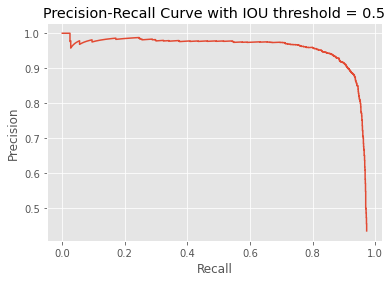

In [26]:
# plot the precision recall curve

%matplotlib inline
plt.plot(prec_rec_df['Recall'], prec_rec_df['Precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title('Precision-Recall Curve with IOU threshold = 0.5')
plt.show();

### Function to get the final class Precision and Recall dataframe given a box_eval_df and an IOU threshold

In [27]:
def get_threshold_prec_recall(box_eval_df, iou_threshold, class_id, num_gt_boxes):
    """
    Returns the final Precision and Recall dataframe given a box_eval_df and an IOU threshold   
    """
    out_df = assign_tp_fp(box_eval_df, iou_threshold)
    out_df = assign_class_precision_recall(out_df, class_id, num_gt_boxes)
    return out_df

In [28]:
# get the total gt boxes in validation_df for the luderick class (label=1) at different iou thresholds
num_gt_boxes = get_total_gt_boxes(validation_df, 0)
thres_prec_rec_df_50 = get_threshold_prec_recall(box_eval_df, 0.5, 0, num_gt_boxes)
thres_prec_rec_df_60 = get_threshold_prec_recall(box_eval_df, 0.6, 0, num_gt_boxes)
thres_prec_rec_df_70 = get_threshold_prec_recall(box_eval_df, 0.7, 0, num_gt_boxes)
thres_prec_rec_df_80 = get_threshold_prec_recall(box_eval_df, 0.8, 0, num_gt_boxes)
thres_prec_rec_df_90 = get_threshold_prec_recall(box_eval_df, 0.9, 0, num_gt_boxes)

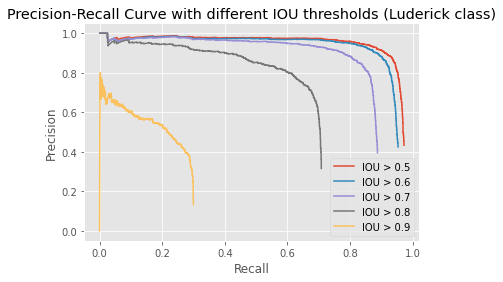

In [29]:
# plot the precision recall curve
plt.plot(thres_prec_rec_df_50['Recall'], thres_prec_rec_df_50['Precision'], label = 'IOU > 0.5')
plt.plot(thres_prec_rec_df_60['Recall'], thres_prec_rec_df_60['Precision'], label = 'IOU > 0.6')
plt.plot(thres_prec_rec_df_70['Recall'], thres_prec_rec_df_70['Precision'], label = 'IOU > 0.7')
plt.plot(thres_prec_rec_df_80['Recall'], thres_prec_rec_df_80['Precision'], label = 'IOU > 0.8')
plt.plot(thres_prec_rec_df_90['Recall'], thres_prec_rec_df_90['Precision'], label = 'IOU > 0.9')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title('Precision-Recall Curve with different IOU thresholds (Luderick class)')
plt.legend()
plt.show();

### Average Precision (AP)

The AP is equal to the numerical integration of the Precision-Recall curve = area under the curve.

In [30]:
def compute_trapezoid_integral(point_a, point_b):
    """
    Computes the trapezoidal numerical integration between two points
    Which is the area of the trapezoid formed by the two points and the x-axis
    where the altitude is (point_b_x - point_a_x) and point_a_y and point_b_y are the two bases
    area_trapezoid = (1/2)*(point_b_x - point_a_x)*(point_a_y + point_b_y)
    """
    return (1/2)*(point_b[0] - point_a[0])*(point_a[1] + point_b[1])

In [31]:
def compute_class_AP(precision_list, recall_list):
    """
    Returns the average precision of a class with a list of precisions and recalls as input
    """
    total_ap = 0
    # start at i = 1 as the trapezoidal rule needs the previous point
    for i in range(1, len(precision_list)):
        # recall is the x-axis and precision the y_axis
        point_a = (recall_list[i-1], precision_list[i-1])
        point_b = (recall_list[i], precision_list[i])
        # compute the area under the two points
        ap = compute_trapezoid_integral(point_a, point_b)
        # add to the total area
        total_ap += ap
    
    return total_ap

In [32]:
ap_50 = compute_class_AP(thres_prec_rec_df_50['Precision'], thres_prec_rec_df_50['Recall'])
ap_60 = compute_class_AP(thres_prec_rec_df_60['Precision'], thres_prec_rec_df_60['Recall'])
ap_70 = compute_class_AP(thres_prec_rec_df_70['Precision'], thres_prec_rec_df_70['Recall'])
ap_80 = compute_class_AP(thres_prec_rec_df_80['Precision'], thres_prec_rec_df_80['Recall'])
ap_90 = compute_class_AP(thres_prec_rec_df_90['Precision'], thres_prec_rec_df_90['Recall'])
print(f'(IOU > 0.5) AP = {ap_50}')
print(f'(IOU > 0.6) AP = {ap_60}')
print(f'(IOU > 0.7) AP = {ap_70}')
print(f'(IOU > 0.8) AP = {ap_80}')
print(f'(IOU > 0.9) AP = {ap_90}')

(IOU > 0.5) AP = 0.9344998578892131
(IOU > 0.6) AP = 0.9101429465133538
(IOU > 0.7) AP = 0.8353489472690536
(IOU > 0.8) AP = 0.6244940297103425
(IOU > 0.9) AP = 0.1651630267636338


### Mean Average Precision (mAP)

 * For each class, get the AP at different IOU thresholds (by recomputing the True Positives) and calculate its mean
     * The general IOU threshold range for mAP computation is from 0.5 to 0.95 with step=0.05 (COCO dataset evaluation)
     * The mAPs single IOU thresholds of 0.5 and 0.75 are usually used as well to 
 * Calculate the mean between the results of each class


In [33]:
def compute_mAp(box_eval_df, preprocessed_df, num_classes):
    """
    Returns the following metrics of a given box evaluation dataframe and the original preprocessed dataframe:
    - mAP@0.5:0.05:0.95
    - mAp@.50
    - mAP@.75 
    """
    # initialize the trhesholds array [0.5, 0.55, ... 0.90, 0.95]
    iou_thresholds = np.arange(0.5, 1, step=0.05)
    
    class_mAP_list = []
    class_mAP50_list = []
    class_mAP75_list = []
    # iterate over the classes
    for i in range(0, num_classes):
        iou_trheshold_ap_list = []
        num_gt_boxes = get_total_gt_boxes(preprocessed_df, i)
        for iou_threshold in iou_thresholds:
            # get the precision-recall dataframe
            prec_rec_df = get_threshold_prec_recall(box_eval_df, iou_threshold, i, num_gt_boxes)
            # get the average precision for this threshold
            ap = compute_class_AP(prec_rec_df['Precision'], prec_rec_df['Recall'])
            iou_trheshold_ap_list.append(ap)
            
        # get the mean of all the threshold APs and add it to the class_mAP list
        class_mAP = sum(iou_trheshold_ap_list) / len(iou_trheshold_ap_list)
        class_mAP_list.append(class_mAP)
        # save the mAP with IOU threshold = 0.5 to its class mAP@50 list
        class_mAP50_list.append(iou_trheshold_ap_list[0])
        # save the mAP with IOU threshold = 0.75 to its class mAP@50 list
        class_mAP75_list.append(iou_trheshold_ap_list[5])
    
    # get the final mAP by computing the mean of all the class mAPs
    mAP = sum(class_mAP_list) / len(class_mAP_list)
    mAP50 = sum(class_mAP50_list) / len(class_mAP50_list)
    mAP75 = sum(class_mAP75_list) / len(class_mAP75_list)
    # multiply by 100 to be in percentage format
    mAP *= 100
    mAP50 *= 100
    mAP75 *= 100
    return mAP, mAP50, mAP75

In [34]:
mAP, mAP50, mAP75 = compute_mAp(box_eval_df, validation_df, NUM_CLASSES)
print(f'Mean Average Precision')
print(f'mAP@0.5:0.05:0.95 = {mAP:.2f}')
print(f'mAp@.50 = {mAP50:.2f}')
print(f'mAp@.75 = {mAP75:.2f}')

Mean Average Precision
mAP@0.5:0.05:0.95 = 64.72
mAp@.50 = 93.45
mAp@.75 = 75.06


### Final model mAP evaluation function

Include all the functions in a single function that only needs the model and the preprocessed Dataset

In [46]:
def evaluate_model_mAP(model, preprocessed_df, num_classes, images_dir):
    """
    Returns the Mean Average Precision (mAP) metrics of an object detection model on a apreprocessed dataframe 
    with the number of classes and images directory as extra parameters
    """
    print("Starting detection on images...")
    start_time = time.time()
    # get the box evaluation dataframe with a low detection threshold
    box_eval_df = get_boxes_evaluation_dataframe(model, preprocessed_df, images_dir, num_classes, detection_threshold=0.01)
    print("Finished image processing")
    print("Starting mAP evaluation...")
    # get the mAP
    mAP, mAP50, mAP75 = compute_mAp(box_eval_df, preprocessed_df, num_classes)
    end_time = time.time()
    print ('Evaluation finished')
    final_time = end_time - start_time
    print(f'Evaluation time = {final_time:.2f} seconds')
    print('-'*50)
    print(f'Mean Average Precision')
    print(f'mAP@0.5:0.05:0.95 = {mAP:.2f}')
    print(f'mAp@.50 = {mAP50:.2f}')
    print(f'mAp@.75 = {mAP75:.2f}')
    print('-'*50)
    torch.cuda.empty_cache()
    metrics_dict = {}
    metrics_dict['mAP@0.5:0.05:0.95'] = mAP
    metrics_dict['mAP@0.50'] = mAP50
    metrics_dict['mAP@0.75'] = mAP75
    return metrics_dict

In [36]:
metrics = evaluate_model_mAP(model_m, validation_df, NUM_CLASSES, IMAGES_DIR)

Starting detection on images...
0.0% of images processed
25.0% of images processed
50.0% of images processed
75.0% of images processed
100% of images processed
Finished image processing
Starting mAP evaluation...
Evaluation finished
Evaluation time = 60.16 seconds
--------------------------------------------------
Mean Average Precision
mAP@0.5:0.05:0.95 = 64.72
mAp@.50 = 93.45
mAp@.75 = 75.06
--------------------------------------------------


## Evaluating and comparing different models and dataset splits

### YOLOv5s small size

In [47]:
# Evaluate YOLOv5s

# validation dataset
print('YOLOv5s Evaluation')
print('-'*50)

# validation dataset
print('Validation Dataset')
print('-'*50)
YOLOv5s_metrics_val = evaluate_model_mAP(model_s, validation_df, NUM_CLASSES, IMAGES_DIR)

# test dataset
print('Test Dataset')
print('-'*50)
YOLOv5s_metrics_test = evaluate_model_mAP(model_s, test_df, NUM_CLASSES, IMAGES_DIR)

YOLOv5s Evaluation
--------------------------------------------------
Validation Dataset
--------------------------------------------------
Starting detection on images...
0.0% of images processed
25.0% of images processed
50.0% of images processed
75.0% of images processed
100% of images processed
Finished image processing
Starting mAP evaluation...
Evaluation finished
Evaluation time = 57.48 seconds
--------------------------------------------------
Mean Average Precision
mAP@0.5:0.05:0.95 = 63.43
mAp@.50 = 93.31
mAp@.75 = 73.81
--------------------------------------------------
Test Dataset
--------------------------------------------------
Starting detection on images...
0.0% of images processed
24.96714848883049% of images processed
49.93429697766098% of images processed
74.90144546649145% of images processed
99.86859395532196% of images processed
100% of images processed
Finished image processing
Starting mAP evaluation...
Evaluation finished
Evaluation time = 50.25 seconds
-----

### YOLOv5m medium size

In [48]:
# Evaluate YOLOv5m

# validation dataset
print('YOLOv5m Evaluation')
print('-'*50)

# validation dataset
print('Validation Dataset')
print('-'*50)
YOLOv5m_metrics_val = evaluate_model_mAP(model_m, validation_df, NUM_CLASSES, IMAGES_DIR)

# test dataset
print('Test Dataset')
print('-'*50)
YOLOv5m_metrics_test = evaluate_model_mAP(model_m, test_df, NUM_CLASSES, IMAGES_DIR)

YOLOv5m Evaluation
--------------------------------------------------
Validation Dataset
--------------------------------------------------
Starting detection on images...
0.0% of images processed
25.0% of images processed
50.0% of images processed
75.0% of images processed
100% of images processed
Finished image processing
Starting mAP evaluation...
Evaluation finished
Evaluation time = 60.72 seconds
--------------------------------------------------
Mean Average Precision
mAP@0.5:0.05:0.95 = 64.72
mAp@.50 = 93.45
mAp@.75 = 75.06
--------------------------------------------------
Test Dataset
--------------------------------------------------
Starting detection on images...
0.0% of images processed
24.96714848883049% of images processed
49.93429697766098% of images processed
74.90144546649145% of images processed
99.86859395532196% of images processed
100% of images processed
Finished image processing
Starting mAP evaluation...
Evaluation finished
Evaluation time = 49.32 seconds
-----

### YOLOv5l large size

In [56]:
# Evaluate YOLOv5l

# validation dataset
print('YOLOv5l Evaluation')
print('-'*50)

# validation dataset
print('Validation Dataset')
print('-'*50)
YOLOv5l_metrics_val = evaluate_model_mAP(model_l, validation_df, NUM_CLASSES, IMAGES_DIR)

# test dataset
print('Test Dataset')
print('-'*50)
YOLOv5l_metrics_test = evaluate_model_mAP(model_l, test_df, NUM_CLASSES, IMAGES_DIR)

YOLOv5l Evaluation
--------------------------------------------------
Validation Dataset
--------------------------------------------------
Starting detection on images...
0.0% of images processed
25.0% of images processed
50.0% of images processed
75.0% of images processed
100% of images processed
Finished image processing
Starting mAP evaluation...
Evaluation finished
Evaluation time = 77.55 seconds
--------------------------------------------------
Mean Average Precision
mAP@0.5:0.05:0.95 = 64.27
mAp@.50 = 93.66
mAp@.75 = 74.15
--------------------------------------------------
Test Dataset
--------------------------------------------------
Starting detection on images...
0.0% of images processed
24.96714848883049% of images processed
49.93429697766098% of images processed
74.90144546649145% of images processed
99.86859395532196% of images processed
100% of images processed
Finished image processing
Starting mAP evaluation...
Evaluation finished
Evaluation time = 68.52 seconds
-----